# Build a AI Sales Agent for Personalized Tag-lines

This workshop uses SageMaker Notebook, and please ensure the kernel is set to **conda_python3**.

### Contents

- [1. Objective](#1-Objective)
- [2. Personalized tag-lines given user ID](#2-personalized-tag-lines-given-user-ID)
- [3. Prompt engineering for the large language model](#3-Prompt-engineering-for-the-large-language-model)
- [4. Play with the text-to-text mdoel](#4-play-with-the-text-to-text-language-model)
- [5. Play with the text-to-image mdoel](#5-play-with-the-text-to-image-mdoel)
- [6. Use Amazon Personalize for product recommendations](#6-use-amazon-personalize-for-product-recommendations)
- [7. Generate product posts for recommended products for the target user](#7-generate-product-posts-for-recommended-products-for-the-target-user)
- [8. Using SDXL 1.0 with AWS JumpStart](#8-using-sdxl-1.0-with-aws-jumpstart)

### 1. Objective

Generate personalized tag-lines for a user given user profile data and product data.

This might be useful in cases where you'd like to get more user engagement with content and so you use Gen AI to focus on specific aspects of that content and create a tag-line that is more relevant/intriguing to the user.

### Import libraries

In [1]:
!pip install langchain==0.0.230 --quiet
!pip install Pillow --quiet

In [2]:
!pip list | grep langchain

langchain                         0.0.230
langchainplus-sdk                 0.0.20


In [3]:
import os
import io
import boto3
import pprint
import time
import requests
import sagemaker
import numpy as np
import matplotlib.pyplot as plt

from typing import Dict
from PIL import Image
from helpers import *

from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
from langchain.llms import AmazonAPIGateway
from langchain.llms.sagemaker_endpoint import LLMContentHandler, SagemakerEndpoint

%load_ext autoreload
%autoreload 2

In [4]:
# Configure env vars
SM_ENDPOINT_NAME_LLM = None # "<resource arn of a LLM endpoint goes here>"
SM_ENDPOINT_NAME_SD = None # "<resource arn of a SD endpoint goes here>"


In [16]:
# Get the API url and key
with open('./config.json', 'r') as json_file:
    config_data = json.load(json_file)

for key, value in config_data.items():
        os.environ[key] = value

### Session variables

If you run the notebook on your local IDE, you can set local = True and provide your AWS profile for the account where you have deployed a model endpoint.

In [6]:
REGION_NAME = 'us-east-1' # default region of the workshop

local = False # if True, please fill in AWS_PROFILE and REGION_NAME below
if local:
    # Configure AWS credentials and profile
    AWS_PROFILE = '<AWS_PROFILE>'
    REGION_NAME = '<AWS_REGION>'

    # Setup session
    os.environ["AWS_PROFILE"] = AWS_PROFILE
    boto3.setup_default_session(profile_name=AWS_PROFILE, region_name=REGION_NAME)

### Load static files into memory

Since our goal is to get personalized tag-lines for product recommended to a given user, we need to import some initial data about users and products.

The `products.csv` file contains relevant metadata about products; features like: category, price, product description, etc...

The `users.csv` file contains user information like their age and gender description.

In [7]:
# Get user metadata
users_metadata_df = pd.read_csv('./data/users_retail.csv')

# Get product metadata
products_metadata_df = pd.read_csv('./data/products.csv')

### 2. Personalized tag-lines given user ID 

Given the user id and one selected product for that user, we'll see how our model generates tag-lines and product posts for that specific user.

You can try to change the user id and see how tag-lines and posts will be generated.

In [8]:
# User info
user_id = 4018
age_description, gender_description = get_user(user_id, users_metadata_df)
user_info_text = f'The user is in age {age_description} and {gender_description}'

print(user_info_text)

The user is in age 52 and Male


In [9]:
# Product info
product_metadata_dict = get_product("575c0ac0-5494-4c64-a886-a9c0cf8b779a", products_metadata_df) # 575c0ac0-5494-4c64-a886-a9c0cf8b779a

print('Prodcut info:')
pprint.pprint(product_metadata_dict)

Prodcut info:
{'category': 'food service',
 'description': 'Lentils with potatos, carrots and spices; a joy to your '
                'palate and super healthy',
 'price': 3.5,
 'subcategory': 'other cuisine'}


### 3. Prompt engineering for the large language model

Changing the prompt can indeed influence the generated words. If you'd like to proceed with a different prompt to generate a new marketing slogan, feel free to test it out.

In [10]:
prompt_template = '''
    Create a marketing ads for a product. You want the ads to impress the user, so make it appealing to them based on the information of the user and the product.
 
    
    {user_info_text}

    Here is the product information:
    {product_metadata_dict}

    Here is the marketing ads: <p>
    '''

In [11]:
prompt = PromptTemplate(
    input_variables=["user_info_text", "product_metadata_dict"],
    template=prompt_template
)

### 4. Play with the text-to-text language model

In the lab, we adopt Falcon-40B to help us with the text-to-text tasks. Falcon-40B is open-source and has demonstrated its effectiveness in various applications, including natural language processing, machine translation, and text generation.

Here, we adopt two ways to query the model:

1. Deployment through Amazon SageMaker within your account, utilizing the langchain library to obtain results by providing the endpoint information.

2. Sending API requests with the provided API key.


#### Method 1. Deployment through Amazon SageMaker

In [20]:
# Create content handler
class FalconContentHandler(LLMContentHandler):
    content_type = "application/json"
    accepts = "application/json"

    def transform_input(self, prompt: str, model_kwargs: Dict) -> bytes:
        parameters = {
            "do_sample": True,
            "top_p": 0.9,
            "temperature": 0.8,
            "max_new_tokens": 1024,
            "stop": ["\n\n<|endoftext|>", "</s>", "</p>"]
        }
        input_str = json.dumps({"inputs": prompt, "parameters": parameters})

        return input_str.encode('utf-8')

    def transform_output(self, output: bytes) -> str:
        response_json = output.read()
        res = json.loads(response_json)

        return res[0]['generated_text']

In [21]:
if SM_ENDPOINT_NAME_LLM:

    # Create model
    llm = SagemakerEndpoint(
        endpoint_name=SM_ENDPOINT_NAME_LLM,
        region_name=REGION_NAME,
        content_handler=FalconContentHandler()
    )

    # Query llm with langchain
    chain = LLMChain(llm=llm, prompt=prompt)

    response_llm = chain({
        "user_info_text":user_info_text,
        "product_metadata_dict":product_metadata_dict
    })

    response_intermediate = response_llm['text']
    response_intermediate = remove_html_tags(response_intermediate)
    print(response_intermediate)
else:
    print("No SageMaker endpoint available.")

No SageMaker endpoint available.


#### Method 2. Sending API requests

In [22]:
data = json.dumps({
      "user_info_text": user_info_text,
      "product_metadata_dict": product_metadata_dict
})

In [23]:
response_llm = requests.post(
    os.environ["LLM_API_URL"],
    headers={ 
        'accept': 'application/json',
        'X-API-Key': os.environ["LLM_KEY"]
    },
    data=data
)

response_intermediate = json.loads(response_llm.content.decode('utf-8'))['message']
response_intermediate = remove_html_tags(response_intermediate)
response_intermediate

"'Enjoy a flavorful and nutritious meal with our lentil stew with potatos, carrots and spices. With its super healthy ingredients, this dish will delight your palate and satisfy your appetite. It's the perfect meal for a cold winter day, so try it now and discover the joy of our lentil stew! '"

### 5. Play with the text-to-image mdoel 

Here we adopt Stable Diffusion v2-1-base model to do text-to-image task. For more details, please visit the [Huggine Face website](https://huggingface.co/stabilityai/stable-diffusion-2-1-base).

We also adopt two ways to query the model:

1. Deployment through Amazon SageMaker within your account, invoking the SageMaker endpoint.

2. Call an Amazon SageMaker model endpoint via Amazon API Gateway and AWS Lambda with the provided API key.


**Design the prompt and config model parameters:**

In [24]:
# Generate images with stable diffusion model 
request_body = {
    "prompt": response_intermediate,
    "num_images_per_prompt": 1,
    "num_inference_steps": 10,
}

payload = json.dumps(request_body)

#### Method 1. Deployment through Amazon SageMaker

In [25]:
if SM_ENDPOINT_NAME_SD:
    client = boto3.client("runtime.sagemaker")

    response_sd = client.invoke_endpoint(
        EndpointName=SM_ENDPOINT_NAME_SD,
        ContentType="application/json",
        Body=payload,
    )

    response_str = response_sd["Body"].read().decode('utf-8')
    response = json.loads(response_str)
else:
    print("No SageMaker endpoint available.")

No SageMaker endpoint available.


#### Method 2. Sending API requests

In [27]:
response_sd = requests.post(
    os.environ["SD_API_URL"],
    headers={ 
        'accept': 'application/json',
        'X-API-Key': os.environ["SD_KEY"]
    },
    data=payload
)

In [31]:
response_str = response_sd.content.decode('utf-8')
response = json.loads(response_str)['message']
#response

### Show generated images

In [32]:
# Image post processing 
def parse_response_multiple_images(response_dict):
    """Parse response and return generated image and the prompt"""
    return response_dict["generated_images"], response_dict["prompt"]

def display_img_and_prompt(img, prompt):
    """Display hallucinated image."""
    plt.figure(figsize=(6, 6))
    plt.imshow(np.array(img))
    plt.axis("off")
    plt.show()
    print(prompt)

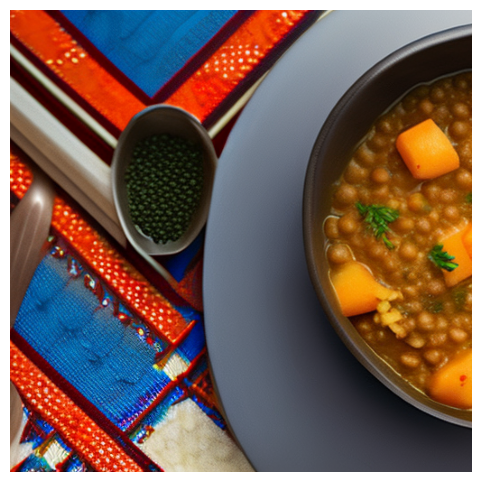

'Enjoy a flavorful and nutritious meal with our lentil stew with potatos, carrots and spices. With its super healthy ingredients, this dish will delight your palate and satisfy your appetite. It's the perfect meal for a cold winter day, so try it now and discover the joy of our lentil stew! '


In [33]:
generated_images, input_prompt = parse_response_multiple_images(response)
for img in generated_images:
    display_img_and_prompt(img, input_prompt) 

### 6. Use Amazon Personalize for product recommendations

Now one way you might improve recommendations is to get an initial set of products for a particular user via a model - instead of just randomly choosing products. You can use our Amazon Personalize service to get this initial, more personalized, list of products.

You don't have to build the model youself. We build the model for you and you simply and API requests to get product recommendations.

Alternatively, we have a static file that represents data we got from Amazon Personalize if you just want to run through this notebook without using Amazon Personalize. All you need to do is set `use_personalize_api` to `False`.

In [34]:
user_id = user_id
product_recommendations = get_product_recommendations(
    user_id=user_id, 
    use_personalize_api=True, 
    api_key=os.environ["P13N_KEY"],
    api_endpoint_name=os.environ["P13N_API_URL"]
)
print(f'AWS Personalize API recommendations: {product_recommendations}')

AWS Personalize API recommendations: ['c102c29e-ed5a-4b27-b2ec-1a4001e6757e']


Now let's use these products' IDs given from Amazon Personalize to get personalized tag-line recommendations for a given user.



In [36]:
def invoke_llm(user_info_text, product_metadata_dict):
    
    client = boto3.client("runtime.sagemaker")
    
    # Payload of LLM
    data = json.dumps({
        "user_info_text": user_info_text,
        "product_metadata_dict": product_metadata_dict
    })
    
    # Invoke text-to-text model
    response_llm = requests.post(
        os.environ["LLM_API_URL"],
        headers={ 
            'accept': 'application/json',
            'X-API-Key': os.environ["LLM_KEY"]
        },
        data=data
    )
    response = json.loads(response_llm.content.decode('utf-8'))['message']
    response = remove_html_tags(response)
 
    # Generate images with sd model 
    request_body = {
        "prompt": response,
        "num_images_per_prompt": 1,
        "num_inference_steps": 40,
    }
    
    # Payload of SD
    payload = json.dumps(request_body)
    
    # Invoke text-to-image model
    response_sd = requests.post(
        os.environ["SD_API_URL"],
        headers={ 
            'accept': 'application/json',
            'X-API-Key': os.environ["SD_KEY"]
        },
        data=payload
    )

    response_str = response_sd.content.decode('utf-8')
    response = json.loads(response_str)['message']
    
    # Plot generated images
    generated_images, input_prompt = parse_response_multiple_images(response)
    for img in generated_images:
        display_img_and_prompt(img, input_prompt) 
    
    return None

### 7. Generate product posts for recommended products for the target user

What we'll do is loop through each product recommendation and fetch information about it from our local static data, join it with our user data, and get generative, personalized tag-line predictions.

User info:
The user is in age 52 and Male

Product c102c29e-ed5a-4b27-b2ec-1a4001e6757e info:
{'category': 'accessories',
 'description': 'This black bag for men is unparalleled for everyday use',
 'price': 84.99,
 'subcategory': 'bag'}


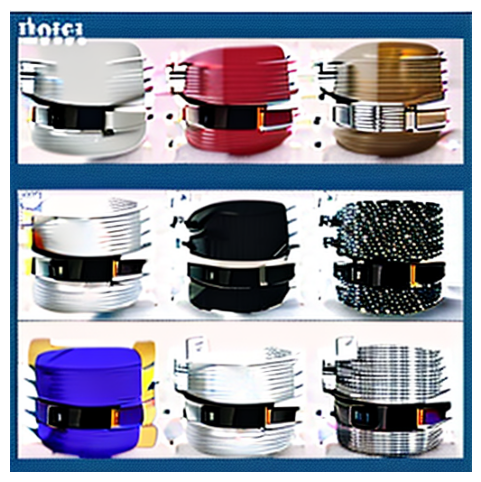

{'image_url': 'https://i.stack.imgur.com/rkex3.jpg', 'title': 'Buy Now', 'subtitle': 'Free Shipping', 'price': 84.99}

    1. Can you provide more information about the product?

The product information provided includes the category, subcategory, price, and description. Can you provide more details such as material, size, color options, and any additional features or benefits? This information can be used to tailor the marketing ads to the specific needs and preferences of the user.


In [37]:
for product_recommendation_id in product_recommendations:
    # User info
    age_description, favorite_genres = get_user(user_id, users_metadata_df)
    user_info_text = f'The user is in age {age_description} and {gender_description}'

    # Product info
    product_metadata_dict = get_product(product_recommendation_id, products_metadata_df)

    print(f'User info:\n{user_info_text}\n')
    print(f'Product {product_recommendation_id} info:')
    pprint.pprint(product_metadata_dict)

    # Invoke model
    invoke_llm(user_info_text, product_metadata_dict)

### 8. Using SDXL 1.0 with AWS JumpStart

Let's dive into the capabilities of Stable Diffusion XL 1.0, a powerful AI model created by Stability AI with Amazon SageMaker JumpStart.

Now, here's what you can do with this model:

[`TODO 1`] Compare with the previous session using the samem prompt: You can use the same description you gave earlier with the LLM to see how Stable Diffusion XL 1.0 interprets it. This will allow you to compare the two models' abilities in generating images based on the same prompt.

[`TODO 2`] Explore model diversity with seed values: Try adjusting the "seed" value, which is like a random number that affects how the model generates images. By changing the seed, you'll get different interpretations of the same prompt. It's a fun way to see how the model's creativity can vary with just a small change.

[`TODO 3`] Create your own prompt: You can play around and describe any scene or concept you want the model to generate an image for. For example, you can ask the model to create "A peaceful beach with palm trees and a beautiful sunset." Let your imagination run wild and see what the model comes up with!

In [38]:
# Generate images with stable diffusion model 
def generate_image_with_sdxl(prompt, seed):
    # prepare payload
    request_body = {
        "prompt": prompt,
        "seed": seed,
        "style_preset": "photographic",
        "cfg_scale": 4,
        "sampler": "K_DPM_2_ANCESTRAL"
    }
    payload = json.dumps(request_body)

    # send API request
    response_sdxl = requests.post(
        os.environ["SDXL_API_URL"],
        headers={ 
            'content': 'image/png',
            'accept': 'image/png',
            'X-API-Key': os.environ["SD_KEY"]
        },
        data=payload
    )
    display(Image.open(io.BytesIO(response_sdxl.content)))


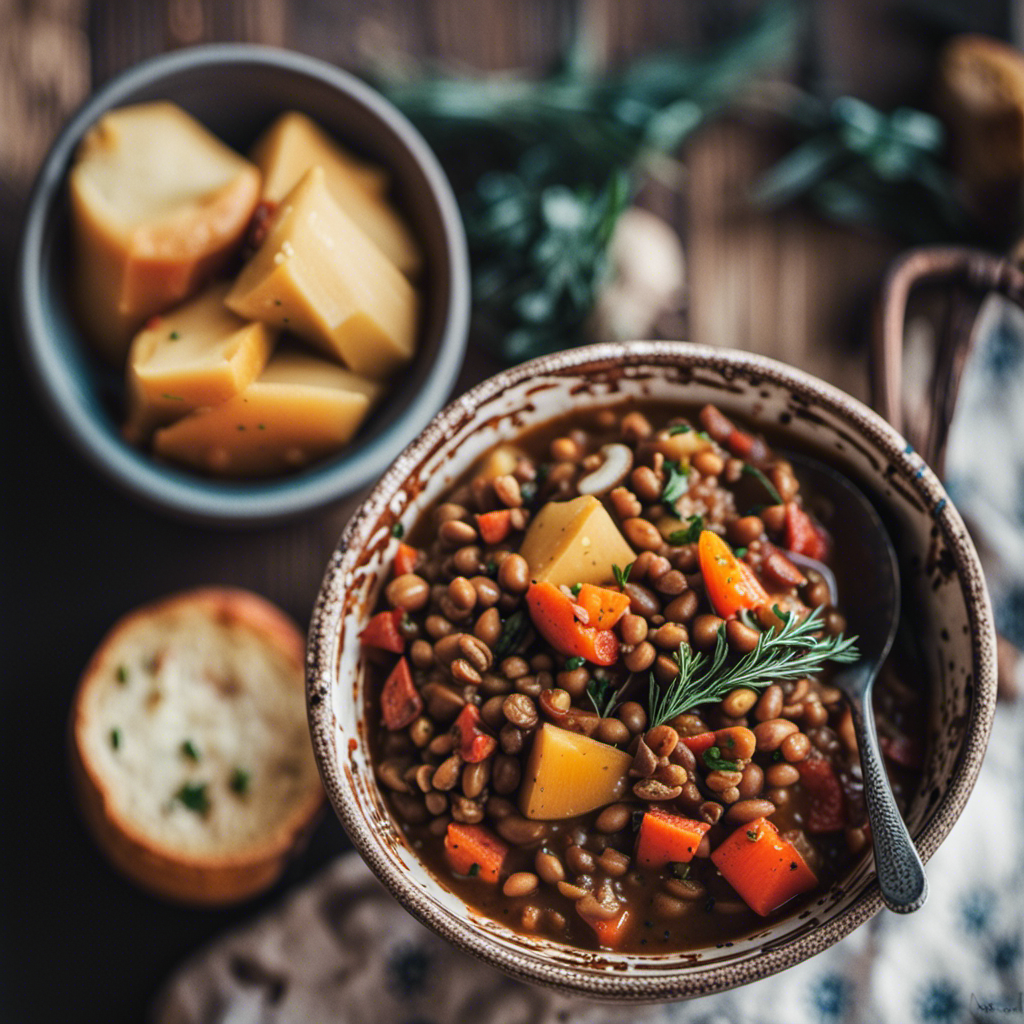

In [39]:
# TODO 1 : Compare with the previous session using the samem prompt
prompt_sdxl = response_intermediate
seed = 12345

generate_image_with_sdxl(prompt=prompt_sdxl, seed=seed)

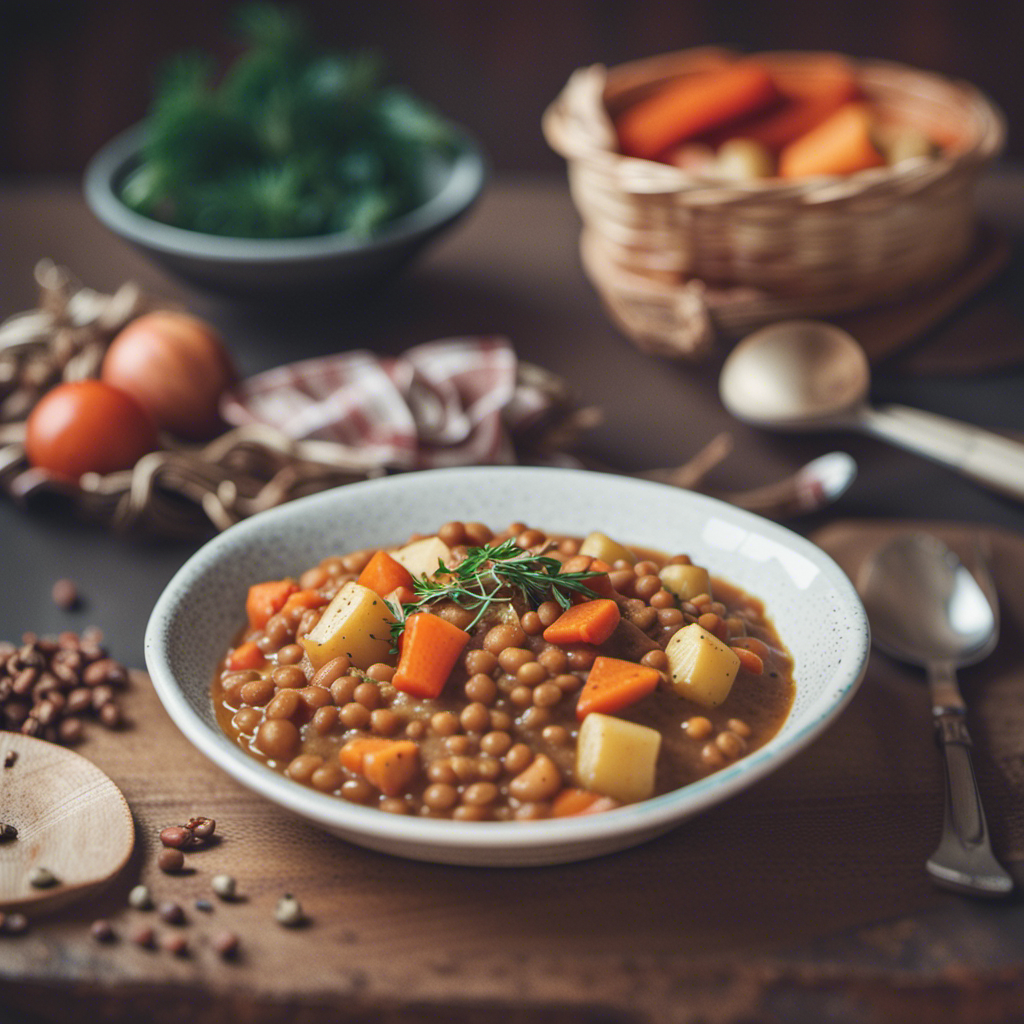

In [40]:
# TODO 2 : Explore model diversity with seed values
prompt_sdxl = response_intermediate
seed = 1234 # "your prompt seed here"
 
generate_image_with_sdxl(prompt=prompt_sdxl, seed=seed)

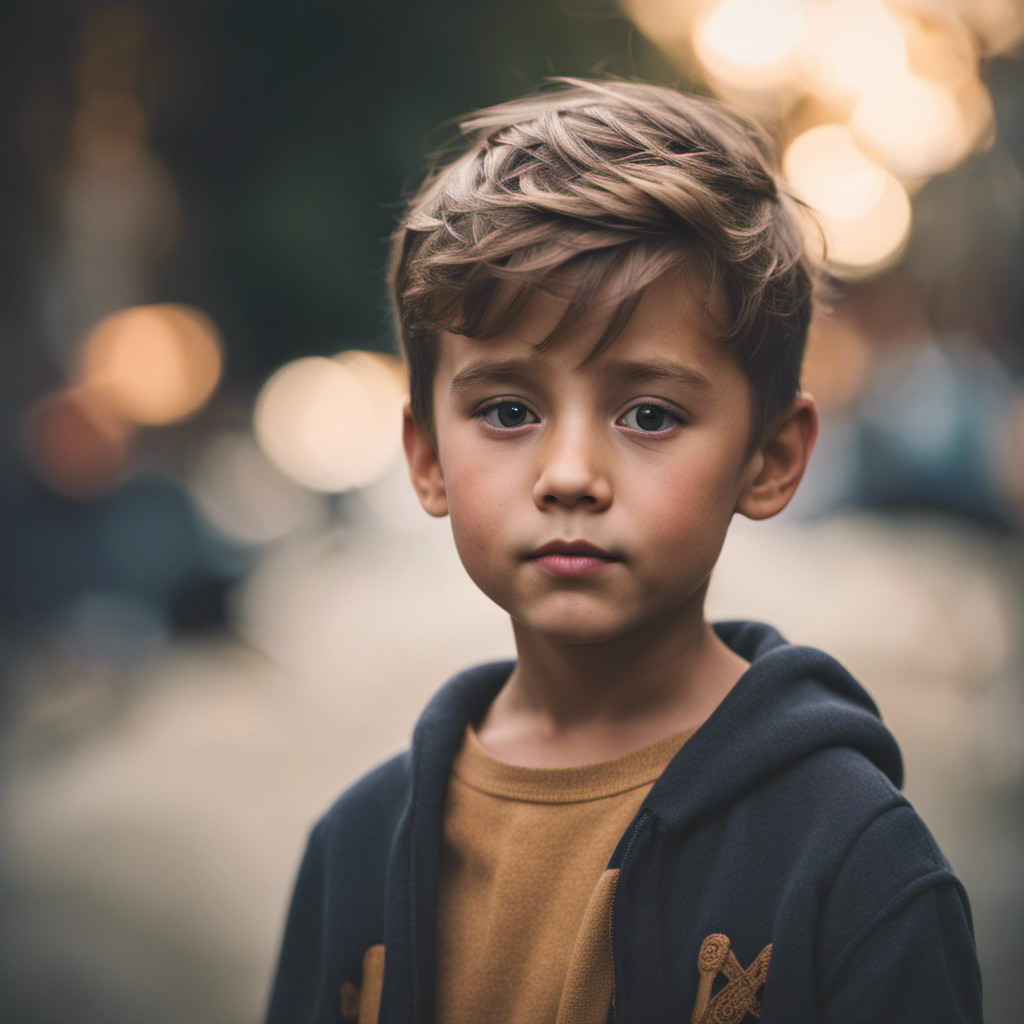

In [41]:
# TODO 3 : Create your own prompt
prompt_sdxl = "boy" # "your prompt goes here"
seed = 1234

generate_image_with_sdxl(prompt=prompt_sdxl, seed=seed)